In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import ipynb_path
import seaborn as sns
import matplotlib.pyplot as plt
from glasbey import create_palette

In [5]:
# add location of spots directory
spots_directory = None

if not spots_directory:
    # look for spots directory using path to this notebook
    spots_directory = Path(ipynb_path.get()).parent.parent / "data/spots"

spots_directory = Path(spots_directory)

print("".join(f"{f.name} \n" for f in spots_directory.glob("*_spots.csv")))

spots_df = pd.read_csv(list(spots_directory.glob("*_spots.csv"))[0])

print(spots_df.columns)

lightsheet_20250131_spots.csv 

Index(['index', 'time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area',
       'radius', 'intensity_mean', 'cycle', 'display_z', 'display_y',
       'display_x', 'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id'],
      dtype='object')


# Explanation of the columns:

## Units of time:

- `frame` Frame of the movie that the nucleus was detected. Serves as an integer coordinate in time.
- `time`: Time in minutes from the start of the movie. Generally, about 3 frames per minute.
- `time_since_nc11`: Time in minutes from the median detected division at the start of nuclear cycle 11, used to compare timing *between movies*. Note that since we can't see the start of nuclear cycle 10 for most nuclei, we use the start of nuclear cycle 11 as our anchor.
- `cycle`: The nuclear cycle of the nucleus. Is based on the timing of the most recently detected division, so it may vary between nuclei in the same frame, if some nuclei have already divided, and some have not.


## Three (ish) different spatial coordinate systems:

### 1. UV Coordinates

The drosophila embryo is unwrapped into three overlapping uv maps ("top", "bottom", "poles"). The `mesh_name` column tracks the uv_map that each nucleus was sourced from.

- `uv_u`, `uv_v`, `uv_z`: the coordinates of the nucleus on the uv map. Please note that unwrapping inherently causes distortion of area and angles. Measurements of distance using the uv map are unlikely to be accurate.



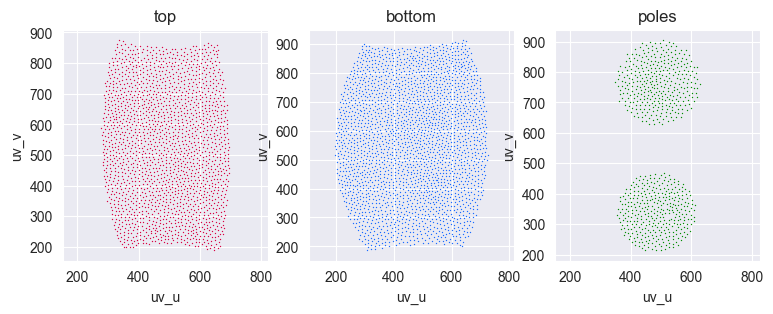

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

max_frame = spots_df["frame"].max()
subset = spots_df[spots_df["frame"] == max_frame]
pal = create_palette(3)

for i, mesh in enumerate(subset["mesh_name"].unique()):
    mesh_ss = subset[subset["mesh_name"] == mesh]

    ax = axes[i]

    sns.scatterplot(mesh_ss, x="uv_u", y="uv_v", color=pal[i], ax=ax, s=1)
    ax.axis("equal")
    ax.set_title(mesh)

plt.show()

### 2. Rectangluar coordinates

After segmentation of the uv maps, the nuclei are mapped back into the original 3d space.

- `z`, `y`, `x`: represent the centroids of the nuclei in 3d space with units of microns
- `px_z`, `px_y`, `px_z`: represent the pixel coordinates of the nuclei centroids. Note that the data is isotropic with um_per_px of 0.525
- `display_z`, `display_y`, `display_x`: reoriented coordinates best for visualizing the entire embryo simultaneously.

Here, we'll use napari to visualize the entire movie. We'll color the nuclei using their distance to the surface, which we got from the uv map. Note that napari should open in a new window. It may take a while to start for the first time if Napari is freshly installed.

In [ ]:
import napari
from napari.utils.theme import available_themes, get_theme, register_theme

# start a napari instance
viewer = napari.Viewer()

# set a gray background - have to create a new theme
custom_theme = get_theme('dark')
custom_theme.id = 'custom'
custom_theme.background = (55, 55, 55)
register_theme('custom', custom_theme, 'custom')
viewer.theme = 'custom'

# choose 4d axes for nuclei
axes = ["frame", "display_z", "display_y", "display_x"]

# color nuclei by distance from surface
palette = sns.color_palette("mako", as_cmap=True)
val = spots_df["distance_from_surface"].values
val = (val - val.min()) / (val.max() - val.min())
color = palette(val)

# make a new points layer, giving every nucleus the same size
points_layer = viewer.add_points(spots_df[axes].values, face_color=color, size=5)

# start the instance of napari
napari.run()

### 3. Cylindrical coordinates

- `AP`: Ranges from 0-1 and reflects the position along the ap axis, as calculated by applying PCA to nuclear positions and taking the longest axis. 0 is the anterior, and 1 is the posterior.
- `theta`: Ranges from -pi to pi and is the angle along the dorsoventral axis. 0 is the most dorsal, and +-pi is the most ventral. positive theta wraps around the ap axis ccw, with the anterior pointing up.

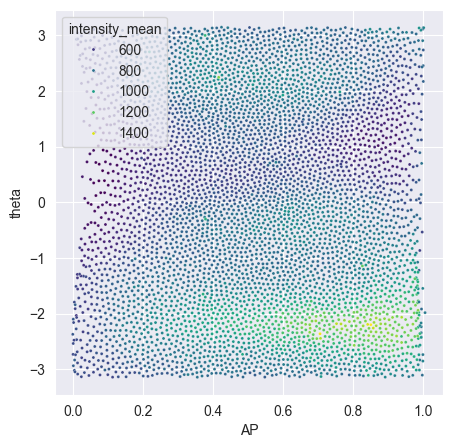

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

max_frame = spots_df["frame"].max()
subset = spots_df[spots_df["frame"] == max_frame]

sns.scatterplot(subset, x="AP", y="theta", hue="intensity_mean", palette="viridis", s=5)
plt.show()

A couple other helpful coordinates might include:

- `uv_distance_from_edge`: Shows how far the nucleus is from the edge of the uv map. Used to determine which nucleus should be accepted during overlaps between two segmentations.
- `distance_from_anterior`, `distance from posterior`: in um.
- `distance_to_pole`: whichever is closest.

## Nucleus area and intensity

Since we don't do full 3d segmentation yet, our measure of nuclear size is through the 2d area of the segmented nucleus in the UV map. Since we know the area distortion, we can correct for this distortion and get the area of the nuclei in px or um. Remember, these nuclear areas are based on the segmentations predicted by a cellpose model, and not expertly curated.

- `uv_area`, `px_area`, `area`: area in uv coordinates, pixels, and um, respectively.
- `area_distortion`: area correction factor (px_area = uv_area * area_distortion)
- `radius`: in um, calculated as sqrt(area / pi)

Nuclear intensity is measured as the average intensity of the pixels segmented in the uv map.

- `intensity_mean`: note that this is not a very quantitative measurement. It varies based on the degree to which the light sheet intersects with the nuclei, and thus varies across the surface of the embryo to a significant degree. Intensity should likely be normalized in some way in space if it is to be used.

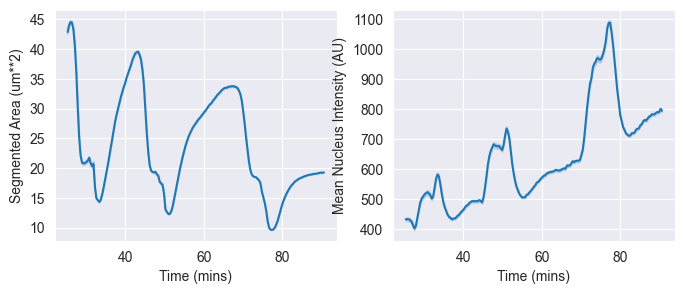

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

subset = spots_df[spots_df["time"] > 25]

sns.lineplot(subset, x="time", y="area", ax=axes[0])
axes[0].set_ylabel("Segmented Area (um**2)")
axes[0].set_xlabel("Time (mins)")

sns.lineplot(subset, x="time", y="intensity_mean", ax=axes[1])
axes[1].set_ylabel("Mean Nucleus Intensity (AU)")
axes[1].set_xlabel("Time (mins)")

plt.show()

## Lineages and Tracking

Nuclei are tracked from frame to frame. A nucleus can only have one parent, but can have multiple children. So, the best direction to go to follow lineages is backwards in time.

- `parent_id`: corresponds to the index of the assigned nucleus from the previous frame. is -1 for nuclei without parents (e.g. first frame of track).

Nuclei are grouped in "tracks" and "tracklets". The track of a nucleus corresponds to the entire lineage, whereas the tracklet of a nucleus corresponds only to that nucleus during that nuclear cycle.

- `track_id`: persists between divisions. All cousin nuclei share the same track_id, and nuclei have the same track_id as their parent nucleus in the previous nuclear cycle.
- `tracklet_id`: maintains within a nuclear cycle, and changes after division. A parent nucleus has a different tracklet_id than its daughter nuclei.

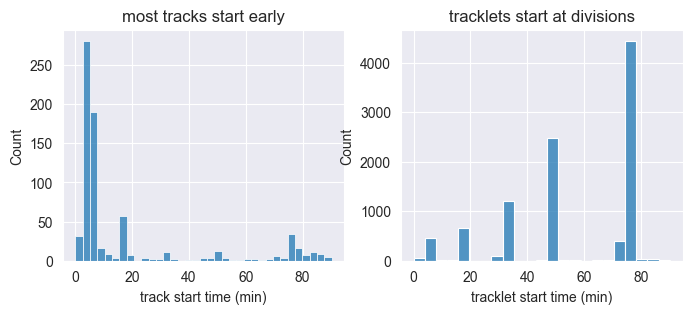

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# we can groupby track and tracklet ids to make visualize lineages and divisions.
track_start_time = spots_df.groupby("track_id")["time"].min()
tracklet_start_time = spots_df.groupby("tracklet_id")["time"].min()

# most tracks start early in the movie, because they persist through divisions
sns.histplot(track_start_time, ax=axes[0])
axes[0].set_xlabel("track start time (min)")
axes[0].set_title("most tracks start early")

# most tracks start early in the movie, because they persist through divisions
sns.histplot(tracklet_start_time, ax=axes[1])
axes[1].set_xlabel("tracklet start time (min)")
axes[1].set_title("tracklets start at divisions")

plt.show()

In [27]:
# we can use napari to visualize the distribution of lineages
viewer = napari.Viewer(ndisplay=3)


# choose 4d axes for nuclei
axes = ["frame", "display_z", "display_y", "display_x"]

# color nuclei by track_id
pal = create_palette(200)
val = spots_df["track_id"].values
color = [pal[v % 200] for v in val]

# make a new points layer, giving every nucleus the same size
points_layer = viewer.add_points(spots_df[axes].values, face_color=color, size=spots_df["radius"]*1.5)

# start the instance of napari
napari.run()